# Dynamic Gating Quickstart
This notebook shows how to read an nwb from the data asset for the dynamic gating experiment. The focus is on aligning neural data to visual and optotagging stimuli. This project shares many similarities with the Visual Behavior Neuropixels, so users are encouraged to check out the documentation for those for additional information and context

In [2]:
import pynwb
from allensdk.brain_observatory.ecephys.dynamic_gating_ecephys_session import DynamicGatingEcephysSession
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pathlib

# ADD METADATA TABLES DESCRIPTION

# Read From Data Asset

Reading a nwb is very simple. Find the session you want to look at, and just give the path to it as seen below. Then, we can use the SDK in a very similar manner to the Visual Behavior Neuropixels to access relevant information.

In [3]:
session = '1227855488'
# REPLACE WITH CORRESPONDING PATH
nwb_file_asset = pynwb.NWBHDF5IO(f'../data/nwb/{session}/{session}.nwb', mode='r', load_namespaces=True)
nwb_file = nwb_file_asset.read()
dynamic_gating_session = DynamicGatingEcephysSession.from_nwb(nwb_file)

We can get a high-level summary of the session by accessing the metadata attribute

In [9]:
dynamic_gating_session.metadata
session_id = dynamic_gating_session.metadata['ecephys_session_id']

/src/allensdk/allensdk/brain_observatory/behavior/data_objects/metadata/subject_metadata/full_genotype.py:57: UserWarning: Unable to parse cre_line from full_genotype
  warnings.warn('Unable to parse cre_line from full_genotype')


We will now get the units and channels for this session. Then we will merge them to get the CCF areas and coordinates for each unit

In [8]:
units = dynamic_gating_session.get_units()
units.columns

Index(['PT_ratio', 'amplitude', 'amplitude_cutoff', 'cluster_id',
       'cumulative_drift', 'd_prime', 'firing_rate', 'isi_label',
       'isi_violations', 'isolation_distance', 'l_ratio', 'local_index',
       'max_drift', 'nn_hit_rate', 'nn_miss_rate', 'peak_channel_id',
       'presence_ratio', 'quality', 'recovery_slope', 'repolarization_slope',
       'silhouette_score', 'snr', 'spread', 'velocity_above', 'velocity_below',
       'waveform_duration'],
      dtype='object')

In [13]:
units = dynamic_gating_session.get_units()
channels = dynamic_gating_session.get_channels()

units_channels = units.merge(channels, left_on='peak_channel_id', right_index=True)
units_channels

,PT_ratio,amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_label,isi_violations,isolation_distance,...,waveform_duration,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,filtering,left_right_ccf_coordinate,probe_channel_number,probe_horizontal_position,probe_id,probe_vertical_position,structure_acronym
id,,,,,,,,,,,,,,,,,,,,,
110690,0.452624,63.019515,0.000866,0,190.63,3.158796,2.008062,No label,0.103565,38.513702,...,0.631826,5050.0,3200.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,5200.0,0,43,313,20,LSc
110691,0.420437,49.059465,0.034183,1,351.32,3.520727,0.976654,No label,0.250177,37.334405,...,0.604355,5050.0,3200.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,5200.0,0,43,313,20,LSc
110692,0.489623,97.558695,0.001143,2,91.27,4.805524,5.308248,No label,0.004235,88.931034,...,0.563149,5050.0,3200.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,5200.0,0,43,313,20,LSc
110696,0.351992,25.331667,0.500000,6,35.00,5.808673,0.037245,No label,0.000000,28.388444,...,0.590620,5050.0,3200.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,5200.0,0,43,313,20,LSc
110693,0.430766,133.156530,0.000404,3,130.67,3.634849,2.177575,No label,0.125812,38.997428,...,0.508208,5050.0,3200.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,5200.0,1,11,313,20,LSc


Now we will look at the brain structures that were recorded during this session

In [20]:
units_channels.value_counts('structure_acronym')

structure_acronym
VISal                  204
CP                     195
SSp                    143
RT                     102
VISp                   100
MOp                     98
LSv                     82
LD                      65
PO                      59
CA3                     58
Track not annotated     57
LGv                     57
VISa                    39
LSr                     37
CA1                     34
CA2                     12
VL                       9
MOs                      1
DG                       1
dtype: int64

# PSTH for image changes
Next, we will grab spike times and calculate the change response for 'good' units. The filtering of the units will depend on the analysis done

In [11]:
spike_times = dynamic_gating_session.spike_times

#first let's sort our units by depth
units_channels = units_channels.sort_values('probe_vertical_position', ascending=False)

#now we'll filter them
good_unit_filter = ((units_channels['snr']>1)&
                    (units_channels['isi_violations']<1)&
                    (units_channels['firing_rate']>0.1))

good_units = units_channels.loc[good_unit_filter]

We can get the times when the image changes occurred from the stimulus presentations table. For now, we'll only take the image changes shown during the active behavior block

In [12]:
stimulus_presentations = dynamic_gating_session.stimulus_presentations
change_times = stimulus_presentations[stimulus_presentations['active']&
                            stimulus_presentations['is_change']]['start_time'].values

In [13]:
#Convenience function to compute the PSTH
def makePSTH(spikes, startTimes, windowDur, binSize=0.001):
    bins = np.arange(0,windowDur+binSize,binSize)
    counts = np.zeros(bins.size-1)
    for i,start in enumerate(startTimes):
        startInd = np.searchsorted(spikes, start)
        endInd = np.searchsorted(spikes, start+windowDur)
        counts = counts + np.histogram(spikes[startInd:endInd]-start, bins)[0]
    
    counts = counts/startTimes.size
    return counts/binSize, bins

We'll include enough time in our plot to see three image responses: the pre-change image response, the change response and the post-change response

In [14]:
# function to look at response for any given area
def get_area_response(area_of_interest:str, good_units:pd.DataFrame, spike_times:dict, time_before_change:float=1) -> [tuple[np.ndarray, np.ndarray]]:
    #Here's where we loop through the units in our area of interest and compute their PSTHs
    area_change_responses = []
    area_units = good_units[good_units['structure_acronym'].str.contains(area_of_interest)]
    duration = 2.5
    for iu, unit in area_units.iterrows():
        unit_spike_times = spike_times[iu]
        unit_change_response, bins = makePSTH(unit_spike_times, 
                                              change_times-time_before_change, 
                                              duration, binSize=0.01)
        area_change_responses.append(unit_change_response)
    area_change_responses = np.array(area_change_responses)
    
    return area_change_responses, bins
    

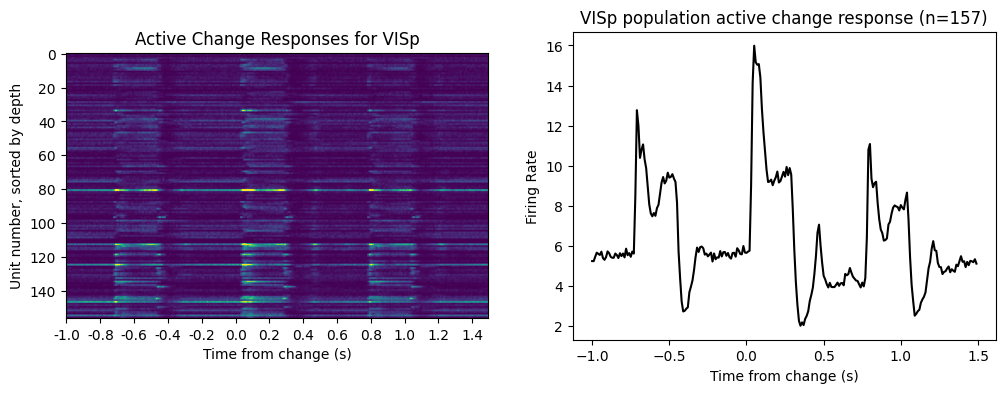

In [15]:
area_of_interest = 'VISp'
time_before_change = 1
area_change_responses, bins = get_area_response(area_of_interest, good_units, spike_times, time_before_change=time_before_change)

#Plot the results
fig, ax = plt.subplots(1,2)
fig.set_size_inches([12,4])

clims = [np.percentile(area_change_responses, p) for p in (0.1,99.9)]
im = ax[0].imshow(area_change_responses, clim=clims)
ax[0].set_title('Active Change Responses for {}'.format(area_of_interest))
ax[0].set_ylabel('Unit number, sorted by depth')
ax[0].set_xlabel('Time from change (s)')
ax[0].set_xticks(np.arange(0, bins.size-1, 20))
_ = ax[0].set_xticklabels(np.round(bins[:-1:20]-time_before_change, 2))

ax[1].plot(bins[:-1]-time_before_change, np.mean(area_change_responses, axis=0), 'k')
ax[1].set_title('{} population active change response (n={})'\
                .format(area_of_interest, area_change_responses.shape[0]))
ax[1].set_xlabel('Time from change (s)')
ax[1].set_ylabel('Firing Rate')

# save
fig.savefig('../results/{}_test_response.png'.format(session_id))

# Plot Receptive Fields

Now, we will look at plotting the receptive fields. First we need to get stimulus presentation data for the receptive field mapping stimulus (gabors).

In [16]:
receptive_field_stim_table = stimulus_presentations[stimulus_presentations['stimulus_name'].str.contains('gabor')]
xs = np.sort(receptive_field_stim_table.position_x.unique()) #positions of gabor along azimuth
ys = np.sort(receptive_field_stim_table.position_y.unique()) #positions of gabor along elevation

In [17]:
# helper function to find the receptive fields
def find_receptive_field(spikes, xs, ys):
    unit_receptive_field = np.zeros([ys.size, xs.size])
    for ix, x in enumerate(xs):
        for iy, y in enumerate(ys):
            stim_times = receptive_field_stim_table[(receptive_field_stim_table.position_x==x)
                                      &(receptive_field_stim_table.position_y==y)]['start_time'].values
            unit_response, bins = makePSTH(spikes, 
                                          stim_times+0.01, 
                                          0.2, binSize=0.001)
            unit_receptive_field[iy, ix] = unit_response.mean()
    return unit_receptive_field

In [18]:
# function to get receptive fields given any area
def get_receptive_fields(area_of_interest:str) -> np.ndarray:
    area_receptive_fields = []
    area_units = good_units[good_units['structure_acronym'].str.contains(area_of_interest)]
    
    for iu, unit in area_units.iterrows():
        unit_spike_times = spike_times[iu]
        unit_receptive_field = find_receptive_field(unit_spike_times, xs, ys)
        area_receptive_fields.append(unit_receptive_field)
    
    return area_receptive_fields

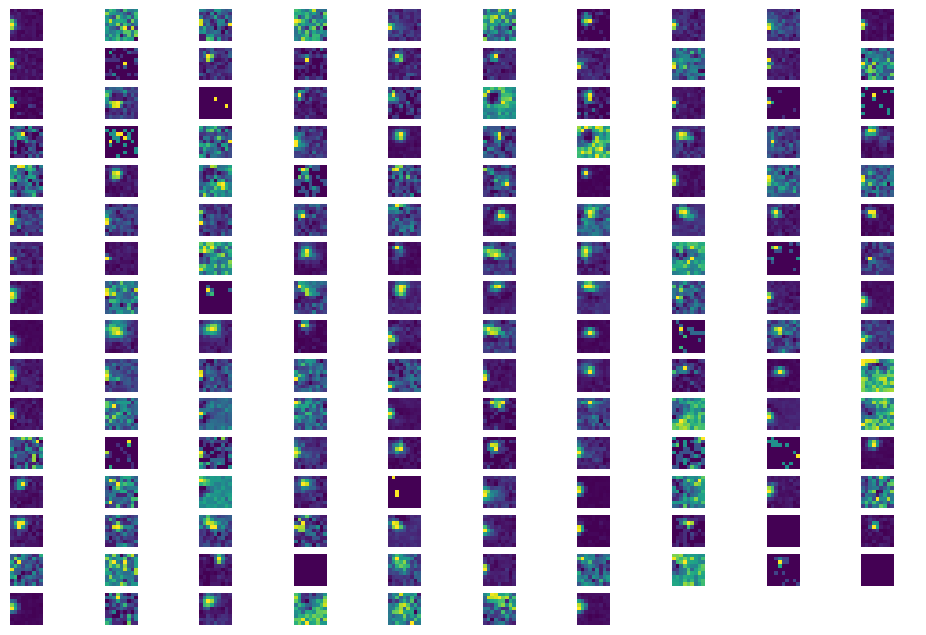

In [19]:
area_of_interest = 'VISp'
area_receptive_fields = get_receptive_fields(area_of_interest)

fig, axes = plt.subplots(int(len(area_receptive_fields)/10)+1, 10)
fig.set_size_inches(12, 8)
for irf, rf in enumerate(area_receptive_fields):
    ax_row = int(irf/10)
    ax_col = irf%10
    axes[ax_row][ax_col].imshow(rf, origin='lower')
for ax in axes.flat:
    ax.axis('off')

# Optotagging

Let's look at the optotagging table now and plot PSTHs triggered on the laser onset.

In [20]:
opto_table = dynamic_gating_session.optotagging_table
time_before = 0.01 # seconds to take before the laser start for PSTH
    
opto_table.head()

,start_time,condition,level,stop_time,stimulus_name,duration
id,,,,,,
0,5495.05177,half-period of a cosine wave,1.70,5496.05177,raised_cosine,1.00
1,5496.79186,half-period of a cosine wave,1.70,5497.79186,raised_cosine,1.00
2,5498.55277,a single square pulse,1.70,5498.56277,pulse,0.01
3,5500.24396,a single square pulse,1.70,5500.25396,pulse,0.01
4,5502.37921,half-period of a cosine wave,1.94,5503.37921,raised_cosine,1.00


In [21]:
# function to get opto response for any given probe
def get_opto_response(probe_id:int) -> tuple[np.ndarray, np.ndarray]:
    duration = opto_table.duration.min() #get the short pulses
    level = opto_table.level.max() #and the high power trials

    cortical_units = good_units[good_units['probe_id'] == probe_id]

    opto_times = opto_table.loc[(opto_table['duration']==duration)&
                                (opto_table['level']==level)]['start_time'].values
    
    duration = 0.03 # total duration of trial for PSTH in seconds
    binSize = 0.001 # 1ms bin size for PSTH
    
    opto_response = []
    unit_id = []
    for iu, unit in cortical_units.iterrows():
        unit_spike_times = spike_times[iu]
        unit_response, bins = makePSTH(unit_spike_times, 
                              opto_times-time_before, duration, 
                              binSize=binSize)

        opto_response.append(unit_response)
        unit_id.append(iu)

    opto_response = np.array(opto_response)
    
    return opto_response, bins

We'll use the probes data from the session and look at the optotagging on a per probe basis

In [22]:
dynamic_gating_session.probes

,name,location,sampling_rate,lfp_sampling_rate,has_lfp_data
id,,,,,
436,probeA,See electrode locations,30000.108336,None,False
437,probeB,See electrode locations,29999.929831,None,False
438,probeC,See electrode locations,30000.225825,None,False
439,probeD,See electrode locations,30000.089837,None,False
440,probeE,See electrode locations,30000.057706,None,False
441,probeF,See electrode locations,30000.103955,None,False


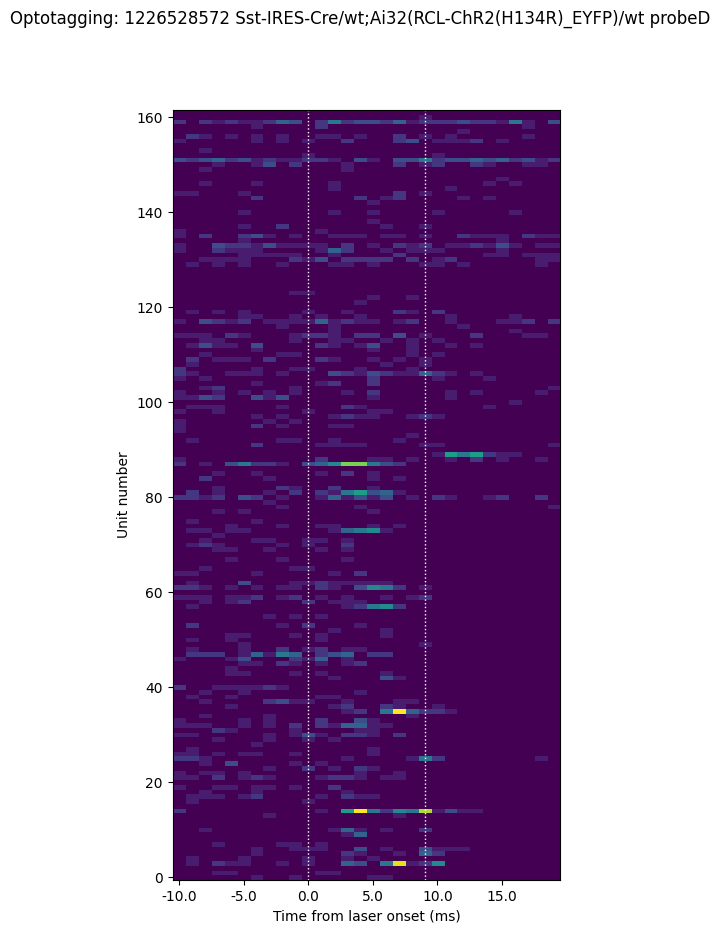

In [23]:
probes = dynamic_gating_session.probes
probe_index = 3

probe_name = probes.iloc[probe_index]['name']
probe_id = probes.index[probe_index]

opto_response, bins = get_opto_response(probe_id)

fig, ax = plt.subplots()
fig.set_size_inches((5,10))
fig.suptitle('Optotagging: ' + str(dynamic_gating_session.metadata['ecephys_session_id'])
             + ' ' + dynamic_gating_session.metadata['full_genotype'] + ' ' + probe_name)
im = ax.imshow(opto_response, 
               origin='lower', aspect='auto',
               )
min_clim_val = 0
max_clim_val = 250
im.set_clim([min_clim_val, max_clim_val])    
[ax.axvline(bound, linestyle=':', color='white', linewidth=1.0)\
     for bound in [10, 19]]
ax.set_xlabel('Time from laser onset (ms)')
ax.set_ylabel('Unit number')
ax.set_xticks(1000*bins[:-1:5])

time_labels = np.round(1000*(bins[:-1:5]-time_before), 0)
_=ax.set_xticklabels(time_labels)

Let's plot the response to the laser over the population

In [24]:
baseline_window = slice(0, 9)  # baseline epoch
response_window = slice(11,18) # laser epoch

response_magnitudes = np.mean(opto_response[:, response_window], axis=1) \
                    - np.mean(opto_response[:, baseline_window], axis=1)

Text(0, 0.5, 'Unit Count')

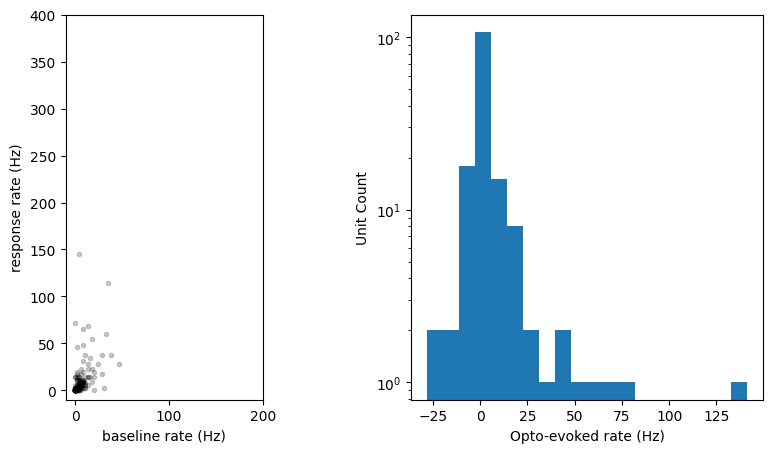

In [25]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(10, 5)

# Plot scatter of opto rate vs baseline rate
axes[0].plot(np.mean(opto_response[:, baseline_window], axis=1),
         np.mean(opto_response[:, response_window], axis=1), 'k.', alpha=0.2)
axes[0].set_xlim([-10, 200])
axes[0].set_ylim([-10, 400])
axes[0].set_aspect('equal')
axes[0].set_ylabel('response rate (Hz)')
axes[0].set_xlabel('baseline rate (Hz)')

# Plot histogram of opto-evoked rate (note log yscale)
_ = axes[1].hist(response_magnitudes, bins=20)
axes[1].set_yscale('log')
axes[1].set_xlabel('Opto-evoked rate (Hz)')
axes[1].set_ylabel('Unit Count')